In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
from astroplan import Observer, FixedTarget
from rubin_scheduler.scheduler.utils import smallest_signed_angle
from rubin_scheduler.utils import Site

In [2]:
# Set up location - include pressure, temperature and relative humidity
# which should trigger inclusion of refraction
lsst = Site('LSST')
observer = Observer(longitude=lsst.longitude*u.deg, latitude=lsst.latitude*u.deg,
                    elevation=lsst.height*u.m*0, name="LSST", 
                    timezone="Chile/Continental", 
                    pressure=lsst.pressure*u.mBa, 
                    temperature=lsst.temperature*u.deg_C, 
                    relative_humidity=lsst.humidity)

In [3]:
# Get information
opsdb = 'ops_rehearsal_apr_2024_v3.db'
conn = sqlite3.connect(opsdb)
dd = pd.read_sql('select * from observations', conn)
rr = pd.read_csv('chris_dictionary', sep='\s+', names=['observationId', 'rotPA'])
dd = rr.join(dd, on='observationId', how='inner', lsuffix='x')

In [4]:
# Recalculate alt/az/parallactic angle - using 'apparent' should include aberration and nutation
coords = SkyCoord(dd['fieldRA'].values, dd['fieldDec'].values, unit='deg', frame='icrs')
targets = FixedTarget(coords)
times = Time(dd['observationStartMJD'], format='mjd', scale='tai')
altaz = observer.altaz(times, targets)
pa = observer.parallactic_angle(times, targets, kind='apparent')

In [5]:
# Calculate skyrotangle (to match imsim)
skyrot = (pa.deg - dd['rotTelPos'].values - 90) % 360

In [6]:
dd['difference'] = np.degrees(smallest_signed_angle(np.radians(dd['rotPA']), np.radians(skyrot)))

In [7]:
# Add indicator for change field and/or change filter
first_in_chunk = np.where(dd['slewTime'] > 5)[0]
chunks = np.zeros(len(dd), int)
for i in first_in_chunk:
    chunks[i:] += 1
dd['chunks'] = chunks

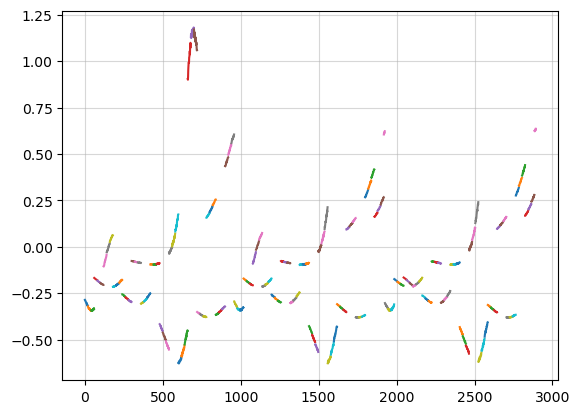

In [8]:
grouped = dd.groupby('chunks')
subset = dd#.query('chunks < 50')
axes = subset.groupby('chunks')['difference'].plot()
plt.grid(alpha=0.5)

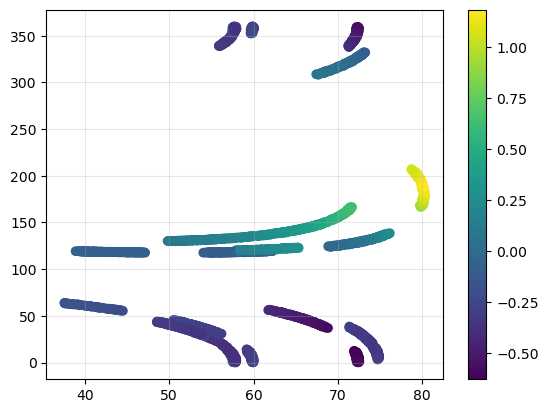

In [9]:
plt.figure()
plt.scatter(altaz.alt.deg, altaz.az.deg, c=dd['difference'])
plt.colorbar()

plt.grid(alpha=0.3)

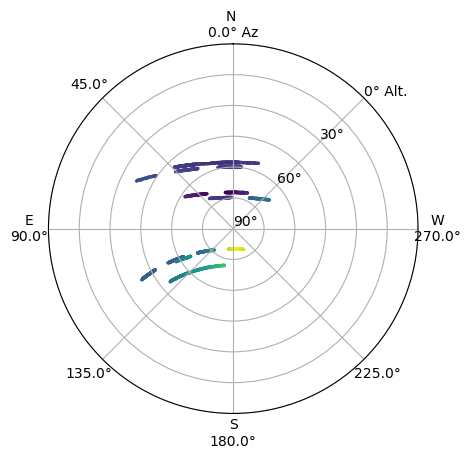

In [12]:
from astroplan.plots import plot_sky

ax = plot_sky(targets, observer, times, style_kwargs={'c': dd['difference'], 's': 1.5})

plt.show()

In [13]:
import bokeh
import bokeh.models
import uranography
import uranography.api
import colorcet

bokeh.io.output_notebook()


data_source = bokeh.models.ColumnDataSource(
    {
        "diff": dd['difference'].values,
        "rotskypos": skyrot,
        "alt": altaz.alt.deg,
        "az": altaz.az.deg,
    }
)

asphere = uranography.api.ArmillarySphere()
asphere.visible_slider_names = []#['alt', 'az']
asphere.connect_controls(data_source)

circles = asphere.plot.circle(
    asphere.proj_transform('x', data_source),
    asphere.proj_transform('y', data_source),
    color=bokeh.transform.linear_cmap("diff", colorcet.palette["rainbow"], low=-0.6, high=1.2),
    size=2,
    source=data_source)
asphere.add_horizon_graticules()

colorbar = circles.construct_color_bar(width=10)
asphere.plot.add_layout(colorbar, 'right')

asphere.show()

Loading BokehJS ...

In general, what is the speed that rotSkyPos would change on the sky? 

In [14]:
from rubin_scheduler.scheduler.utils import generate_all_sky

rotTelPos = 0

sky = generate_all_sky(nside=128)
coords = SkyCoord(sky['ra'], sky['dec'], unit='deg', frame='icrs')
targets = FixedTarget(coords)
times = Time(dd['observationStartMJD'].iloc[0], format='mjd', scale='tai')
altaz = observer.altaz(times, targets)
pa = observer.parallactic_angle(times, targets, kind='apparent')
skyrot = (pa.deg - rotTelPos - 90) % 360

In [15]:
times2 = times + 1*u.minute
altaz2 = observer.altaz(times2, targets)
pa2 = observer.parallactic_angle(times2, targets, kind='apparent')
skyrot2 = (pa2.deg - rotTelPos - 90) % 360

In [16]:
change = np.degrees(smallest_signed_angle(np.radians(skyrot), np.radians(skyrot2)))
available_sky = np.where((altaz.alt.deg < 86.5) & (altaz.alt.deg > 20), True, False)
change[~available_sky] = np.nan

In [17]:
data_source = bokeh.models.ColumnDataSource(
    {
        "change": change,
        "alt": altaz.alt.deg,
        "az": altaz.az.deg,
    }
)
low = np.nanmin(change)
high = np.nanmax(change)

asphere = uranography.api.ArmillarySphere()
asphere.visible_slider_names = []#['alt', 'az']
asphere.connect_controls(data_source)

circles = asphere.plot.circle(
    asphere.proj_transform('x', data_source),
    asphere.proj_transform('y', data_source),
    color=bokeh.transform.linear_cmap("change", colorcet.palette["rainbow"], low=low, high=high),
    size=2,
    source=data_source)
asphere.add_horizon_graticules()

colorbar = circles.construct_color_bar(width=10)
asphere.plot.add_layout(colorbar, 'right')
asphere.plot.title = "Change in rotSkyPos (deg/min)"
asphere.show()

Camera rotator max speed is 3.5 degrees/second.